# Test Inference: Combined 4-class, then Two-Level

In [8]:
import os
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

from transformers import AutoImageProcessor, Swinv2ForImageClassification, AutoConfig, Swinv2Model, Swinv2Config

os.environ.setdefault('TRANSFORMERS_OFFLINE', '1')
os.environ.setdefault('HF_HUB_DISABLE_TELEMETRY', '1')

try:
    from safetensors.torch import load_file as safe_load_file
    HAVE_SAFETENSORS = True
except Exception:
    HAVE_SAFETENSORS = False

device = 'cuda' if torch.cuda.is_available() else ('mps' if getattr(torch.backends, 'mps', None) and torch.backends.mps.is_available() else 'cpu')
device = torch.device(device)
print('Device:', device)

Device: mps


In [10]:
BASE_DIR = './test'
TEST_META = os.path.join(BASE_DIR, 'test_metadata.json')
COMBINED_DIR = './models/combined_swinv2_model'
LEVEL1_DIR = './models/checkpoint-8448-level1'
LEVEL2_DIR = './models/checkpoint-5688-level2'

platform_to_id = {'dall-E3': 0, 'im': 1, 'sd': 2}

meta_test = pd.read_json(TEST_META)
if isinstance(meta_test['image_file'].iloc[0], list):
    meta_test['image_file'] = meta_test['image_file'].str[0]

def _to_full(rel):
    return os.path.normpath(os.path.join(BASE_DIR, rel))

mt = meta_test[['id','image_file','status','platform']].copy()
mt['full_path'] = mt['image_file'].apply(_to_full)
mt = mt[mt['full_path'].apply(os.path.exists)].reset_index(drop=True)

mt['status'] = mt['status'].astype(str).str.lower()
mt['y_true_4'] = np.where(mt['status']=='real', 0, 1 + mt['platform'].map(platform_to_id))
mt = mt.dropna(subset=['y_true_4']).reset_index(drop=True)
mt['y_true_4'] = mt['y_true_4'].astype(int)

print('Combined 4-class test rows:', len(mt))

Combined 4-class test rows: 1563


{'combined_4class_test_accuracy': 0.9206653870761357, 'n': 1563}


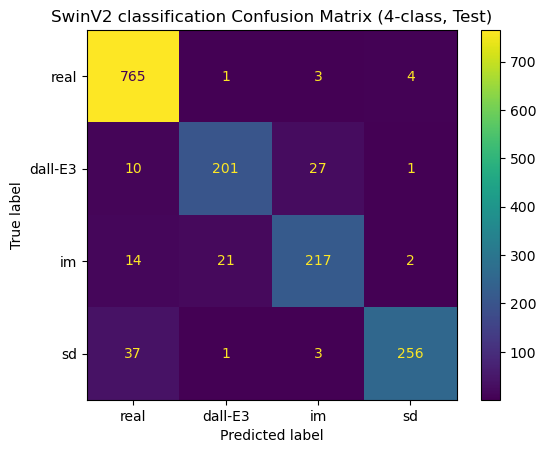

In [16]:
# Combined 4-class evaluation
id2label_c = {0:'real', 1:'dall-E3', 2:'im', 3:'sd'}
label2id_c = {v:k for k,v in id2label_c.items()}
proc_c = AutoImageProcessor.from_pretrained(COMBINED_DIR, local_files_only=True)
config_c = AutoConfig.from_pretrained(COMBINED_DIR, num_labels=4, id2label=id2label_c, label2id=label2id_c, local_files_only=True)
model_c = Swinv2ForImageClassification.from_pretrained(COMBINED_DIR, config=config_c, local_files_only=True)
model_c.to(device); model_c.eval()

class CombinedTestDS(Dataset):
    def __init__(self, df, processor):
        self.df = df; self.p = processor
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        img = Image.open(r['full_path']).convert('RGB')
        pv = self.p(images=img, return_tensors='pt')['pixel_values'].squeeze(0)
        return {'x': pv, 'y': int(r['y_true_4'])}

def collate_c(b):
    return {'x': torch.stack([t['x'] for t in b]), 'y': torch.tensor([t['y'] for t in b], dtype=torch.long)}

dl_c = DataLoader(CombinedTestDS(mt, proc_c), batch_size=32, shuffle=False, num_workers=0, collate_fn=collate_c)

Yt, Yp = [], []
with torch.no_grad():
    for batch in dl_c:
        out = model_c(pixel_values=batch['x'].to(device))
        preds = torch.argmax(out.logits, dim=-1).cpu().numpy().tolist()
        Yp += preds
        Yt += batch['y'].cpu().numpy().tolist()

acc = accuracy_score(Yt, Yp)
cm = confusion_matrix(Yt, Yp, labels=[0,1,2,3])
print({'combined_4class_test_accuracy': acc, 'n': len(Yt)})
ConfusionMatrixDisplay(cm, display_labels=['real','dall-E3','im','sd']).plot(values_format='d')
plt.title('SwinV2 classification Confusion Matrix (4-class, Test)')
plt.show()

In [12]:
# Two-level pipeline setup
status_to_id = {'real': 0, 'fake': 1}
platform_to_id = {'dall-E3': 0, 'im': 1, 'sd': 2}
df = meta_test[['id','image_file','status','platform']].copy()
df['full_path'] = df['image_file'].apply(_to_full)
df['exists'] = df['full_path'].apply(os.path.exists)
df = df[df['exists']].reset_index(drop=True)
df['y1_true'] = df['status'].map(lambda s: status_to_id.get(str(s).lower(), np.nan))
df['y2_true'] = df['platform'].map(platform_to_id)
df = df.dropna(subset=['y1_true']).reset_index(drop=True)

processor1 = AutoImageProcessor.from_pretrained(LEVEL1_DIR, local_files_only=True)
processor2 = AutoImageProcessor.from_pretrained(LEVEL2_DIR, local_files_only=True)
target = processor1.size['height'] if isinstance(processor1.size, dict) and 'height' in processor1.size else (processor1.size if isinstance(processor1.size, int) else 256)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
resnet_base_transforms = transforms.Compose([
    transforms.Resize(target),
    transforms.CenterCrop(target),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

class Level1Dataset(Dataset):
    def __init__(self, df, processor):
        self.df = df; self.p = processor
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        img = Image.open(r['full_path']).convert('RGB')
        pv = self.p(images=img, return_tensors='pt')['pixel_values'].squeeze(0)
        return {'x': pv, 'y': int(r['y1_true']), 'id': int(r['id'])}

class Level2Dataset(Dataset):
    def __init__(self, df_fake, processor, resnet_tx):
        self.df = df_fake; self.p = processor; self.rx = resnet_tx
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        img = Image.open(r['full_path']).convert('RGB')
        pv_s = self.p(images=img, return_tensors='pt')['pixel_values'].squeeze(0)
        pv_r = self.rx(img)
        return {'xs': pv_s, 'xr': pv_r, 'y': int(r['y2_true']), 'id': int(r['id'])}

# Only build Level 1 dataloader here. Level 2 will be built on predicted-fake items after Level 1.
dl1 = DataLoader(Level1Dataset(df, processor1), batch_size=16, shuffle=False, num_workers=0)

{'level1_accuracy': 0.9788867562380038}


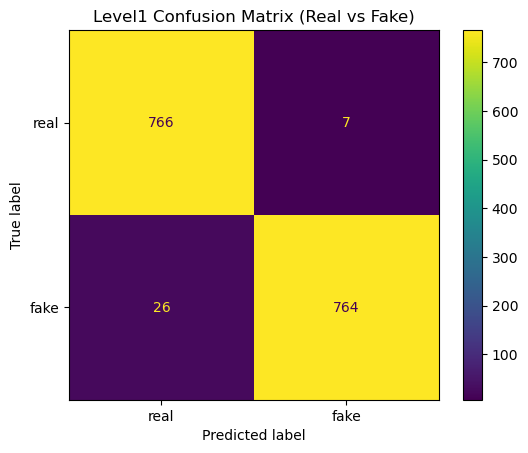

In [13]:
# Level 1 eval
config1 = AutoConfig.from_pretrained(LEVEL1_DIR, num_labels=2, id2label={0:'real',1:'fake'}, label2id={'real':0,'fake':1}, local_files_only=True)
model1 = Swinv2ForImageClassification.from_pretrained(LEVEL1_DIR, config=config1, local_files_only=True)
model1.to(device); model1.eval()
Y1t, Y1p, IDS1 = [], [], []
with torch.no_grad():
    for b in dl1:
        out = model1(pixel_values=b['x'].to(device))
        pr = torch.argmax(out.logits, dim=-1).cpu().numpy().tolist()
        Y1p += pr; Y1t += b['y'].cpu().numpy().tolist(); IDS1 += b['id'].cpu().numpy().tolist()
acc1 = accuracy_score(Y1t, Y1p)
cm1 = confusion_matrix(Y1t, Y1p, labels=[0,1])
print({'level1_accuracy': acc1})
ConfusionMatrixDisplay(cm1, display_labels=['real','fake']).plot(values_format='d')
plt.title('Level1 Confusion Matrix (Real vs Fake)')
plt.show()

{'level2_accuracy_cascade_gated': 0.9410994764397905, 'n': 764}


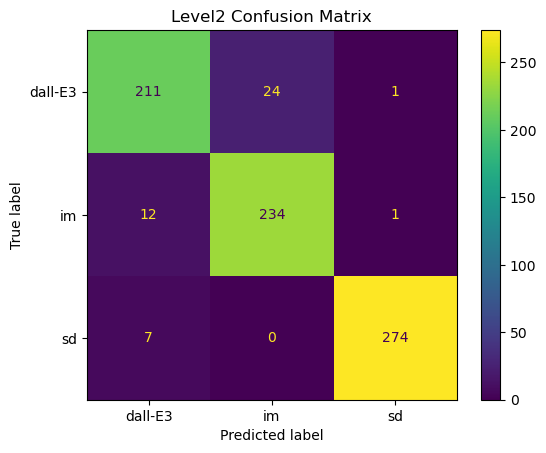

In [ ]:
# Level 2 eval (cascade-gated: run on ALL items predicted fake by Level 1)
class ResNetSwinClassifier(nn.Module):
    def __init__(self, num_labels, swin_config_source=LEVEL1_DIR):
        super().__init__()
        try:
            self.resnet = models.resnet50(weights=None)
        except Exception:
            self.resnet = models.resnet50(pretrained=False)
        self.resnet.fc = nn.Identity()
        resnet_out_dim = 2048
        swin_config = Swinv2Config.from_pretrained(swin_config_source, local_files_only=True)
        self.swin = Swinv2Model(swin_config)
        swin_out_dim = self.swin.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(resnet_out_dim + swin_out_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_labels),
        )
    def forward(self, pixel_values=None, resnet_pixel_values=None):
        s_out = self.swin(pixel_values=pixel_values)
        s_feat = getattr(s_out, 'pooler_output', None)
        if s_feat is None:
            s_feat = s_out.last_hidden_state.mean(dim=1)
        r_feat = self.resnet(resnet_pixel_values)
        x = torch.cat([r_feat, s_feat], dim=1)
        return self.classifier(x)

# Build cascade-gated subsets based on Level 1 predictions
y1_pred_df = pd.DataFrame({'id': IDS1, 'y1_pred': Y1p})
df_join = df.merge(y1_pred_df, on='id', how='left')
# All predicted fakes (may include real images -> false positives)
df_fake_pred_all = df_join[df_join['y1_pred'] == 1].reset_index(drop=True)
# Subset with available labels for evaluation only
df_fake_pred_eval = df_fake_pred_all.dropna(subset=['y2_true']).reset_index(drop=True)

if not HAVE_SAFETENSORS:
    raise ImportError('safetensors is required for Level2 weights')
model2 = ResNetSwinClassifier(num_labels=3)
state = safe_load_file(os.path.join(LEVEL2_DIR, 'model.safetensors'))
model2.load_state_dict(state, strict=False)
model2.to(device); model2.eval()

# Inference dataset for ALL predicted fakes (no label required)
class Level2InferDataset(Dataset):
    def __init__(self, df_src, processor, resnet_tx):
        self.df = df_src; self.p = processor; self.rx = resnet_tx
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        img = Image.open(r['full_path']).convert('RGB')
        xs = self.p(images=img, return_tensors='pt')['pixel_values'].squeeze(0)
        xr = self.rx(img)
        return {'xs': xs, 'xr': xr, 'id': int(r['id'])}

# Build loaders
from torch.utils.data import DataLoader

dl2_all = DataLoader(Level2InferDataset(df_fake_pred_all, processor2, resnet_base_transforms), batch_size=8, shuffle=False, num_workers=0)
# For evaluation where labels exist
if len(df_fake_pred_eval) > 0:
    dl2_eval = DataLoader(Level2Dataset(df_fake_pred_eval, processor2, resnet_base_transforms), batch_size=8, shuffle=False, num_workers=0)
else:
    dl2_eval = None

# Inference on ALL predicted fakes
IDS2_ALL, Y2P_ALL = [], []
with torch.no_grad():
    for b in dl2_all:
        lg = model2(pixel_values=b['xs'].to(device), resnet_pixel_values=b['xr'].to(device))
        pr = torch.argmax(lg, dim=-1).cpu().numpy().tolist()
        Y2P_ALL += pr; IDS2_ALL += b['id'].cpu().numpy().tolist()

print({'predicted_fakes_total': len(IDS2_ALL)})

# Optional evaluation on the subset with labels
if dl2_eval is not None:
    Y2t_eval, Y2p_eval = [], []
    with torch.no_grad():
        for b in dl2_eval:
            lg = model2(pixel_values=b['xs'].to(device), resnet_pixel_values=b['xr'].to(device))
            pr = torch.argmax(lg, dim=-1).cpu().numpy().tolist()
            Y2p_eval += pr; Y2t_eval += b['y'].cpu().numpy().tolist()
    acc2 = accuracy_score(Y2t_eval, Y2p_eval)
    cm2 = confusion_matrix(Y2t_eval, Y2p_eval, labels=[0,1,2])
    print({'level2_accuracy_cascade_gated_truefakes': acc2, 'n_eval': len(Y2t_eval), 'n_all': len(IDS2_ALL)})
    ConfusionMatrixDisplay(cm2, display_labels=['dall-E3','im','sd']).plot(values_format='d')
    plt.title('Level2 Confusion Matrix (Cascade-Gated True Fakes)')
    plt.show()

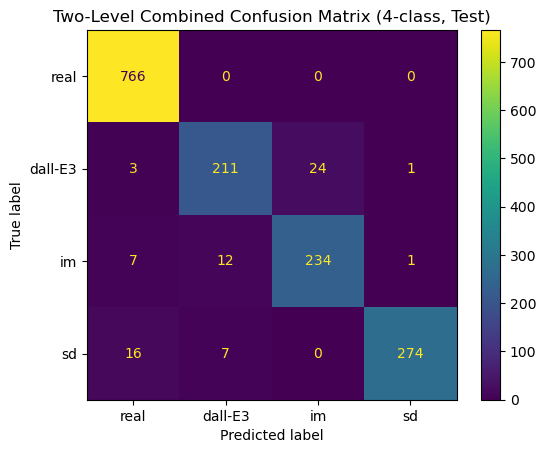

{'two_level_combined_4class_accuracy': 0.9543701799485861, 'n': 1556}


In [ ]:
# Combined 4-class from two-level predictions (uses Level1 preds + Level2 preds on ALL predicted fakes)
pred1_df = pd.DataFrame({'id': IDS1, 'y1_pred': Y1p})
pred2_df = pd.DataFrame({'id': IDS2_ALL, 'y2_pred': Y2P_ALL})
comb = df.merge(pred1_df, on='id', how='left').merge(pred2_df, on='id', how='left')

# Ground-truth 4-class: real=0, dall-E3=1, im=2, sd=3
def true4(row):
    if int(row['y1_true']) == 0:
        return 0
    return 1 + int(row['y2_true']) if pd.notna(row['y2_true']) else np.nan

# Predicted 4-class from cascade
def pred4(row):
    if pd.isna(row['y1_pred']):
        return np.nan
    if int(row['y1_pred']) == 0:
        return 0
    return 1 + int(row['y2_pred']) if pd.notna(row['y2_pred']) else np.nan

comb['y_true_4'] = comb.apply(true4, axis=1)
comb['y_pred_4'] = comb.apply(pred4, axis=1)
mask = comb['y_true_4'].notna() & comb['y_pred_4'].notna()

y_true4 = comb.loc[mask, 'y_true_4'].astype(int).to_numpy()
y_pred4 = comb.loc[mask, 'y_pred_4'].astype(int).to_numpy()

cm4 = confusion_matrix(y_true4, y_pred4, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm4, display_labels=['real','dall-E3','im','sd']).plot(values_format='d')
plt.title('Two-Level Combined Confusion Matrix (4-class, Test)')
plt.show()
acc4 = accuracy_score(y_true4, y_pred4)
print({'two_level_combined_4class_accuracy': acc4, 'n': int(mask.sum())})